
### 1 What are Graph Neural Networks (GNNs)?

Graph Neural Networks are a family of neural network architectures that operate directly on **graphs**. A graph is made of:

- **Nodes (vertices)**: entities (e.g., documents, users, molecules).
- **Edges**: relationships or connections between nodes (e.g., citations, friendships, chemical bonds).
- **Node features**: descriptive information for each node (e.g., word counts in a paper, user profile info).

Traditional neural networks (like MLPs or CNNs) work well on grids (images) or sequences (text), but they are not designed for arbitrary graph structures. **GNNs** propagate and aggregate information along edges, allowing each node to update its representation based on its neighbors. This makes them especially powerful for tasks such as:

- Node classification (predicting a label for each node)
- Link prediction (predicting missing or future edges)
- Graph classification (predicting a label for an entire graph)

In [8]:
import tensorflow as tf
import numpy as np
import scipy.sparse as sp
from sklearn.model_selection import train_test_split  
import matplotlib.pyplot as plt

from spektral.datasets import citation



## 2. Loading the Cora Citation Dataset

The Cora dataset is a classic benchmark for node classification on citation networks:

- **Nodes**: scientific publications.
- **Edges**: citation links between publications.
- **Node features**: bag-of-words representation of each paper (binary word indicators).
- **Labels**: research topic of each paper.

Spektral provides a convenient loader that returns:

- **`x`**: node features matrix.
- **`a`**: adjacency matrix (graph structure).
- **`y`**: one-hot encoded labels.
- **`train_mask`, `val_mask`, `test_mask`**: boolean masks that tell us which nodes belong to the training, validation, and test splits.

In [9]:
from spektral.datasets import citation

cora = citation.Cora()

# Access the single graph (Cora has only one graph)
graph = cora[0]  # or cora.graphs[0]

# Unpack the dataset attributes
x = graph.x  # Node features (NumPy array)
a = graph.a  # Adjacency matrix (SciPy sparse matrix)
y = graph.y  # Node labels (NumPy array, one-hot encoded)
train_mask = cora.mask_tr
val_mask = cora.mask_va
test_mask = cora.mask_te

print("Cora dataset loaded successfully!\n")
print(f"Type of x (features): {type(x)}")
print(f"Type of a (adjacency): {type(a)}")
print(f"Type of y (labels): {type(y)}")
print(f"Shape of x: {x.shape}")
print(f"Shape of a: {a.shape}")
print(f"Shape of y: {y.shape}")
print(f"Train nodes: {train_mask.sum()} | Val nodes: {val_mask.sum()} | Test nodes: {test_mask.sum()}")

Cora dataset loaded successfully!

Type of x (features): <class 'numpy.ndarray'>
Type of a (adjacency): <class 'scipy.sparse._csr.csr_array'>
Type of y (labels): <class 'numpy.ndarray'>
Shape of x: (2708, 1433)
Shape of a: (2708, 2708)
Shape of y: (2708, 7)
Train nodes: 140 | Val nodes: 500 | Test nodes: 1000


## 3 Basic Dataset Statistics


- **Number of nodes** in the graph.
- **Number of edges** (undirected).
- **Feature dimensionality** (how many features per node).
- **Number of classes** (distinct research topics).

In [10]:
# 4.1 Compute and display basic graph statistics

num_nodes = x.shape[0]
num_features = x.shape[1]

# For an undirected graph stored as a symmetric adjacency matrix,
# the number of edges is half the number of non-zero entries.
num_edges = a.nnz // 2 if (a != a.T).nnz == 0 else a.nnz

num_classes = y.shape[1]

print(f"Number of nodes:        {num_nodes}")
print(f"Number of edges:        {num_edges}")
print(f"Feature dimensionality: {num_features}")
print(f"Number of classes:      {num_classes}")


Number of nodes:        2708
Number of edges:        5278
Feature dimensionality: 1433
Number of classes:      7


## 4. Inspecting Node Features and Labels

- A few **node feature vectors**.
- The **label distribution** across classes.

Remember:

- Each row in `x` is the feature vector for one node (paper).
- Each row in `y` is a one-hot vector encoding the class of that node.

In [11]:
# 4. Show a few node feature vectors and labels

num_examples = 5

print(f"Showing {num_examples} example nodes (features and labels):\n")
for i in range(num_examples):
    feature_vector = x[i]
    label_vector = y[i]
    class_index = label_vector.argmax()
    print(f"Node {i}:")
    print(f"  Feature vector (first 10 values): {feature_vector[:10]}")
    print(f"  Label one-hot: {label_vector}")
    print(f"  Class index:   {class_index}\n")


Showing 5 example nodes (features and labels):

Node 0:
  Feature vector (first 10 values): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Label one-hot: [0. 0. 0. 1. 0. 0. 0.]
  Class index:   3

Node 1:
  Feature vector (first 10 values): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Label one-hot: [0. 0. 0. 0. 1. 0. 0.]
  Class index:   4

Node 2:
  Feature vector (first 10 values): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Label one-hot: [0. 0. 0. 0. 1. 0. 0.]
  Class index:   4

Node 3:
  Feature vector (first 10 values): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  Label one-hot: [1. 0. 0. 0. 0. 0. 0.]
  Class index:   0

Node 4:
  Feature vector (first 10 values): [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  Label one-hot: [0. 0. 0. 1. 0. 0. 0.]
  Class index:   3



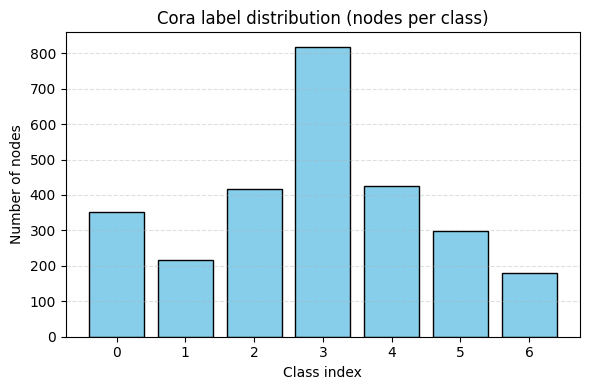

In [12]:
# 4 Label distribution (bar chart)
import matplotlib.pyplot as plt

# Convert one-hot labels to class indices
class_indices = y.argmax(axis=1)

# Count how many nodes per class
unique_classes, counts = np.unique(class_indices, axis=0, return_counts=True)

plt.figure(figsize=(6, 4))
plt.bar(unique_classes, counts, color="skyblue", edgecolor="black")
plt.xlabel("Class index")
plt.ylabel("Number of nodes")
plt.title("Cora label distribution (nodes per class)")
plt.xticks(unique_classes)
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


## 5. Additional Graph Insights

Finally, we can look at a couple of simple graph-level statistics using the adjacency matrix:

- **Average node degree**: on average, how many neighbors each node has.
- **Sparsity** of the adjacency matrix: what fraction of possible edges are actually present.

how dense or sparse the citation network is.


In [13]:
# 5 Simple graph statistics: average degree and sparsity

# Degree of each node is the number of neighbors
# For a sparse matrix, we can use the sum over rows
node_degrees = np.array(a.sum(axis=1)).flatten()
avg_degree = node_degrees.mean()

# Sparsity: 1 - (number of non-zero entries / total possible entries)
num_possible_edges = num_nodes * num_nodes
sparsity = 1.0 - (a.nnz / num_possible_edges)

print(f"Average node degree: {avg_degree:.2f}")
print(f"Adjacency matrix sparsity: {sparsity * 100:.4f}%")


Average node degree: 3.90
Adjacency matrix sparsity: 99.8561%


In [14]:
# 6.1 Save features, labels, adjacency, and masks to ../data/

import os

# Construct the data directory path relative to this notebook
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), "data")
os.makedirs(DATA_DIR, exist_ok=True)

x_path = os.path.join(DATA_DIR, "X.npy")
y_path = os.path.join(DATA_DIR, "y.npy")
a_path = os.path.join(DATA_DIR, "A.npz")
train_mask_path = os.path.join(DATA_DIR, "train_mask.npy")
val_mask_path = os.path.join(DATA_DIR, "val_mask.npy")
test_mask_path = os.path.join(DATA_DIR, "test_mask.npy")

# Save dense arrays
np.save(x_path, x)
np.save(y_path, y)
np.save(train_mask_path, train_mask)
np.save(val_mask_path, val_mask)
np.save(test_mask_path, test_mask)

# Save sparse adjacency matrix
sp.save_npz(a_path, a)

print("Saved Cora dataset to disk:\n")
print(f"  Features:     {x_path}")
print(f"  Labels:       {y_path}")
print(f"  Adjacency:    {a_path}")
print(f"  Train mask:   {train_mask_path}")
print(f"  Val mask:     {val_mask_path}")
print(f"  Test mask:    {test_mask_path}")


Saved Cora dataset to disk:

  Features:     /home/rebu/Desktop/Projects/Interns/Icog labs/training-tasks/GNN-Models/data/X.npy
  Labels:       /home/rebu/Desktop/Projects/Interns/Icog labs/training-tasks/GNN-Models/data/y.npy
  Adjacency:    /home/rebu/Desktop/Projects/Interns/Icog labs/training-tasks/GNN-Models/data/A.npz
  Train mask:   /home/rebu/Desktop/Projects/Interns/Icog labs/training-tasks/GNN-Models/data/train_mask.npy
  Val mask:     /home/rebu/Desktop/Projects/Interns/Icog labs/training-tasks/GNN-Models/data/val_mask.npy
  Test mask:    /home/rebu/Desktop/Projects/Interns/Icog labs/training-tasks/GNN-Models/data/test_mask.npy
